# Irannian Leopard Population in Bamu National Park
## Discrete Ages

### 99/12/11

Population contains two sex and two age categories; Female ang male, adult and subadult. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

Data collected in Bamu Park has been given in the table:

|      | Female | Male |
| ---  |  ---   | ---  |
|Adults|    3   |   1  |
|Subadults|  1  |   1  |

For this model we define sex ratio as the ratio of the number of males per female and based on our assumptions it is constant during the time. We actually don't know the ratio of male to female newborns, but we are estimating the ratio by the ratio of total males to total females. total population contains adults and subadults.

\begin{align}
& sex ratio = \frac{male adults + male subadults}{female adults + female subadults}\\
& P(new born = male) \approx \frac{male adults + male subadults}{adults + subadults} = \frac{2}{6}
\end{align}


In [16]:
sex_ratio = 0.5 
p_male    = 2/6


# initial condition in Bamu park
adults    = [[1, 3]]
subadults = [[1, 1]]

In [17]:
p_give_birth = 1
# poisson distribution automatically gives zeros children sometimes
# p_give_birth makes no change as it is equal 1

def born(parents, p_give_birth, lam):
    nm, nf = parents
    if nm != 0: # Just one male adult is enough
        who_gives_birth = np.random.uniform(0, 1, nf)
        where = np.where(who_gives_birth <= p_give_birth)
        mothers = np.size(where)
        childs = np.random.poisson(lam, mothers)
        childs = np.sum(childs[childs <= 6])
    else:
        childs = 0
    determine_sex = np.random.uniform(0, 1, childs)
    where = np.where(determine_sex < p_male)
    male_newborn   = np.size(where)
    female_newborn = childs - male_newborn
    newborn = [male_newborn, female_newborn]
    
    return newborn

In [18]:
def dy(adults, death_prob, max_age): # no dy in subadults, equal dy probability for all male-female and ages
    ages = np.shape(adults)[0]
    if ages > (max_age - puberty_age):
        adults = adults[0:(max_age - puberty_age + 1)] #noone can live more than max_age
    else:
        max_age = ages + puberty_age
    for i in range(max_age - puberty_age): #i = (age - puberty_age)
        nm, nf = adults[i]
        nm = np.size(np.where(np.random.uniform(0, 1, nm) > death_prob))
        nf = np.size(np.where(np.random.uniform(0, 1, nf) > death_prob))
        adults[i] = nm, nf
        
    return adults

In [19]:
def evolution(adults, subadults, years, mean_life_time, puberty_age, p_give_birth, lam):
    death_prob     = 1 / mean_life_time

    total_subadults = subadults
    for year in range(years):
        if year < (puberty_age - 1):
            subadults = np.concatenate((subadults, [born(adults[year], p_give_birth, lam)]), axis = 0)
            total_subadults = np.concatenate((total_subadults, [subadults.sum(axis = 0)]), axis = 0)
            new_adults = dy(adults[year], death_prob)
            adults    = np.concatenate((adults, [new_adults]), axis = 0)

        else:
            new_adults = dy(np.add(adults[year], subadults[0]), death_prob)
            adults = np.concatenate((adults, [new_adults]), axis = 0)
            subadults = np.delete(subadults, (0), axis = 0)
            subadults = np.concatenate((subadults, [born(adults[year], p_give_birth, lam)]), axis = 0)
            total_subadults = np.concatenate((total_subadults, [subadults.sum(axis = 0)]), axis = 0)
    
    return adults, total_subadults

In [20]:
def p_pyramid(adults, subadults, years, mean_life_time, puberty_age, p_give_birth, lam, max_age):
    death_prob     = 1 / mean_life_time

    for year in range(years):
        parents   = adults.sum(axis = 0)

        subadults = np.concatenate(([born(parents, p_give_birth, lam)], subadults), axis = 0)
        adults    = np.concatenate(([subadults[puberty_age]], adults), axis = 0)
        adults    = dy(adults, death_prob, max_age)
        subadults = np.delete(subadults, (puberty_age), axis = 0)

    population = np.zeros((max_age + 1, 2))
    ages = np.min((max_age + 1, np.shape(adults)[0] + puberty_age))

    for i in range(ages):
        if i < puberty_age:
            population[i] = subadults[i]
        else:
            population[i] = adults[i - puberty_age]
            
    return population

Text(0.5, 1.0, 'Poisson distribution for children born to a mother\n $\\lambda = $ 0.5')

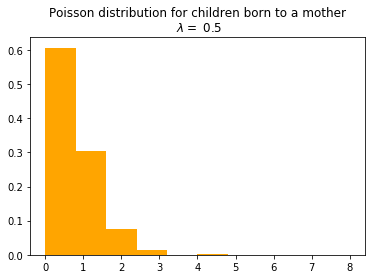

In [21]:
lam = 0.5
mothers = 10000000
myarray = np.random.poisson(lam, mothers)
weights = np.ones_like(myarray)/float(len(myarray))
plt.hist(myarray, color = 'orange', weights = weights)

plt.title(f"Poisson distribution for children born to a mother\n $\lambda = $ {lam}")

# plt.savefig("poisson.png")

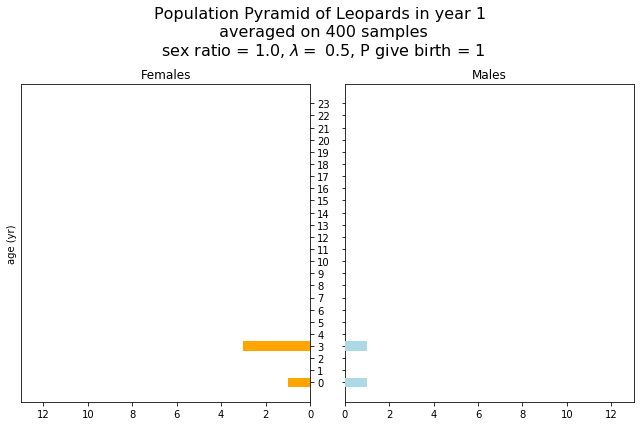

Wall time: 786 ms


In [38]:
%%time

p_male = 3/6
sex_ratio = p_male / (1 - p_male)
years = 0
puberty_age = 3
mean_life_time = 23
p_give_birth = 1
lam = 0.5
max_age = 23

subadults_0 = np.array(np.concatenate(([[1, 1]], [[0, 0]], [[0, 0]]), axis = 0))
adults_0 = np.array([[1, 3]])



average_on = 400

population = p_pyramid(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age)
males   = population[:, 0]
females = population[:, 1]

for ave in range(average_on - 1):
    new_pop = p_pyramid(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age)
    males   = np.concatenate((males, new_pop[:, 0]), axis = 0)
    females =  np.concatenate((females, new_pop[:, 1]), axis = 0)


males   = males.reshape(-1, max_age+1)
females = females.reshape(-1, max_age+1)

males_m   = males.mean(axis = 0)
males_std = np.std(males, axis = 0)

females_m = females.mean(axis = 0) 
females_std = np.std(females, axis = 0)


ages = np.arange(max_age + 1)


fig, axes = plt.subplots(ncols=2, figsize = (9, 6) , sharey=True)

fig.suptitle(f"Population Pyramid of Leopards in year {years + 1}\n averaged on {average_on} samples\n sex ratio = {np.round(sex_ratio, 2)}, $\lambda =$ {lam}, P give birth = {p_give_birth}", fontsize = 16)


axes[0].barh(ages, females_m, xerr = females_std, align='center', color='orange', zorder=10)
axes[0].set(title='Females')
axes[1].barh(ages, males_m, xerr = males_std, align='center', color='lightblue', zorder=10)
axes[1].set(title='Males')
axes[1].set_xlim(0, 13)

axes[0].invert_xaxis()
axes[0].set(yticks = ages, yticklabels = ages)
axes[0].yaxis.tick_right()
axes[0].set_ylabel("age (yr)")
axes[0].set_xlim(13, 0)

fig.tight_layout()
fig.subplots_adjust(wspace = 0.12)
fig.subplots_adjust(top = 0.80)
plt.show()

# plt.savefig(f"p_pyramid{years}.png")



## Includig abnormal morality rate

In [39]:
def p_pyramid_amortality(adults, subadults, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_morality):
    death_prob     = 1 / mean_life_time + a_morality

    for year in range(years):
        parents   = adults.sum(axis = 0)

        subadults = np.concatenate(([born(parents, p_give_birth, lam)], subadults), axis = 0)
        adults    = np.concatenate(([subadults[puberty_age]], adults), axis = 0)
        adults    = dy(adults, death_prob, max_age)
        subadults = np.delete(subadults, (puberty_age), axis = 0)

    population = np.zeros((max_age + 1, 2))
    ages = np.min((max_age + 1, np.shape(adults)[0] + puberty_age))

    for i in range(ages):
        if i < puberty_age:
            population[i] = subadults[i]
        else:
            population[i] = adults[i - puberty_age]
            
    return population

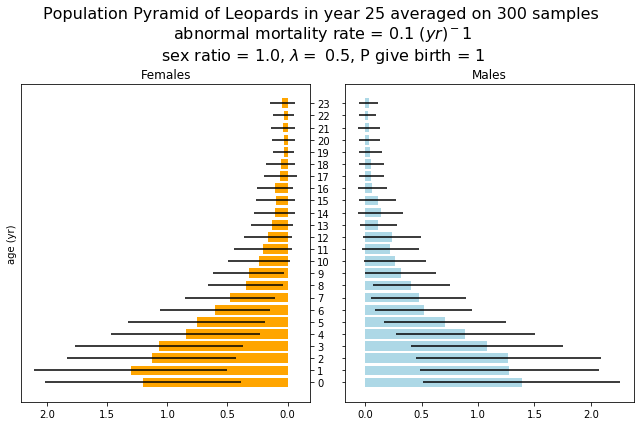

Wall time: 7.59 s


In [40]:
%%time

p_male = 3/6
sex_ratio = p_male / (1 - p_male)
years = 24
puberty_age = 3
mean_life_time = 23
p_give_birth = 1
lam = 0.5
max_age = 23
a_mortality = 0.1

subadults_0 = np.array(np.concatenate(([[1, 1]], [[0, 0]], [[0, 0]]), axis = 0))
adults_0 = np.array([[1, 3]])



average_on = 300

population = p_pyramid_amortality(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_mortality)
males   = population[:, 0]
females = population[:, 1]

for ave in range(average_on - 1):
    new_pop = p_pyramid_amortality(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_mortality)
    males   = np.concatenate((males, new_pop[:, 0]), axis = 0)
    females =  np.concatenate((females, new_pop[:, 1]), axis = 0)


males   = males.reshape(-1, max_age+1)
females = females.reshape(-1, max_age+1)

males_m   = males.mean(axis = 0)
males_std = np.std(males, axis = 0)

females_m = females.mean(axis = 0) 
females_std = np.std(females, axis = 0)


ages = np.arange(max_age + 1)


fig, axes = plt.subplots(ncols=2, figsize = (9, 6) , sharey=True)

fig.suptitle(f"Population Pyramid of Leopards in year {years + 1} averaged on {average_on} samples\n abnormal mortality rate = {a_mortality} $(yr)^{-1}$\n sex ratio = {np.round(sex_ratio, 2)}, $\lambda =$ {lam}, P give birth = {p_give_birth}", fontsize = 16)


axes[0].barh(ages, females_m, xerr = females_std/2, align='center', color='orange', zorder=10)
axes[0].set(title='Females')
axes[1].barh(ages, males_m, xerr = males_std/2, align='center', color='lightblue', zorder=10)
axes[1].set(title='Males')

axes[0].invert_xaxis()
axes[0].set(yticks = ages, yticklabels = ages)
axes[0].yaxis.tick_right()
axes[0].set_ylabel("age (yr)")


fig.tight_layout()
fig.subplots_adjust(wspace = 0.12)
fig.subplots_adjust(top = 0.80)
plt.show()

# plt.savefig("p_pyramid_am.png")

## Abnormal Mortality Other Way
"amortality" parameter here ,eans how many leopards dy each year because of abnormal reasons. 

In [41]:
def abnormal_dy(adults, death_prob, max_age, a_morality): # no dy in subadults, equal dy probability for all male-female and ages
    ages = np.shape(adults)[0]
    if ages > (max_age - puberty_age):
        adults = adults[0:(max_age - puberty_age + 1)] #noone can live more than max_age
    else:
        max_age = ages + puberty_age
    for i in range(max_age - puberty_age): #i = (age - puberty_age)
        nm, nf = adults[i]
        nm = np.size(np.where(np.random.uniform(0, 1, int(nm)) > death_prob))
        nf = np.size(np.where(np.random.uniform(0, 1, int(nf)) > death_prob))
        adults[i] = nm, nf
    #how many abnormal death
    x, y = np.where(population != 0)
    where = list(zip(x, y))
    kill = random.choices(where, k = int(a_mortality))
    population[i in kill] -= 1
    return adults

In [44]:
def p_pyramid_amortality_new(adults, subadults, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_morality):
    death_prob     = 1 / mean_life_time

    for year in range(years):
        parents   = adults.sum(axis = 0)

        subadults = np.concatenate(([born(parents, p_give_birth, lam)], subadults), axis = 0)
        adults    = np.concatenate(([subadults[puberty_age]], adults), axis = 0)
        adults    = abnormal_dy(adults, death_prob, max_age, a_mortality)
        subadults = np.delete(subadults, (puberty_age), axis = 0)

    population = np.zeros((max_age + 1, 2))
    ages = np.min((max_age + 1, np.shape(adults)[0] + puberty_age))

    for i in range(ages):
        if i < puberty_age:
            population[i] = subadults[i]
        else:
            population[i] = adults[i - puberty_age]
            
    return population

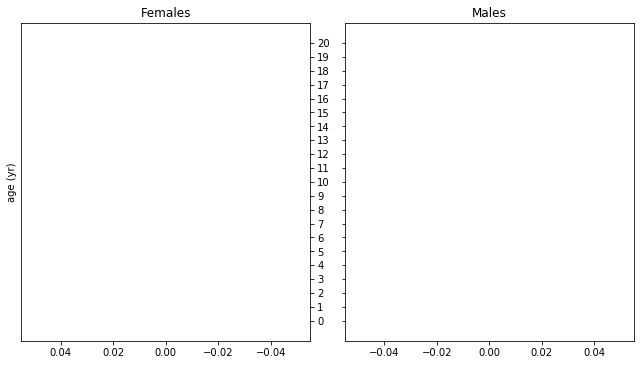

Wall time: 665 ms


<Figure size 432x288 with 0 Axes>

In [211]:
%%time

p_male = 2/6
sex_ratio = p_male / (1 - p_male)
years = 20
puberty_age = 3
mean_life_time = 23
p_give_birth = 1
lam = 5
max_age = 20
a_mortality = 1

subadults_0 = np.array(np.concatenate(([[1, 1]], [[0, 0]], [[0, 0]]), axis = 0))
adults_0 = np.array([[1, 3]])



average_on = 1

population = p_pyramid_amortality(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_mortality)
males   = population[:, 0]
females = population[:, 1]

for ave in range(average_on - 1):
    new_pop = p_pyramid_amortality(adults_0, subadults_0, years, mean_life_time, puberty_age, p_give_birth, lam, max_age, a_mortality)
    males   = np.concatenate((males, new_pop[:, 0]), axis = 0)
    females =  np.concatenate((females, new_pop[:, 1]), axis = 0)


males   = males.reshape(-1, max_age+1)
females = females.reshape(-1, max_age+1)

males_m   = males.mean(axis = 0)
males_std = np.std(males, axis = 0)

females_m = females.mean(axis = 0) 
females_std = np.std(females, axis = 0)


ages = np.arange(max_age + 1)


fig, axes = plt.subplots(ncols=2, figsize = (9, 6) , sharey=True)

# fig.suptitle(f"Population Pyramid of Leopards in year {years + 1} averaged on {average_on} samples\n abnormal mortality rate = {a_mortality} for individual $(yr)^{-1}$\n sex ratio = {np.round(sex_ratio, 2)}, $\lambda =$ {lam}, P give birth = {p_give_birth}", fontsize = 16)


axes[0].barh(ages, females_m, xerr = females_std, align='center', color='orange', zorder=10)
axes[0].set(title='Females')
axes[1].barh(ages, males_m, xerr = males_std, align='center', color='lightblue', zorder=10)
axes[1].set(title='Males')

axes[0].invert_xaxis()
axes[0].set(yticks = ages, yticklabels = ages)
axes[0].yaxis.tick_right()
axes[0].set_ylabel("age (yr)")


fig.tight_layout()
fig.subplots_adjust(wspace = 0.12)
fig.subplots_adjust(top = 0.80)
plt.show()

plt.savefig("p_pyramid_amnew.png")

## Random choice instead of poisson

Not all matings lead to puppies and the probability to have 2 puppies is more than 1 and 3 and the other cases are too rare. In this case I am tuning the probabilities in "born choice" function. 

In [45]:
import random

def born_choice(parents):
    nm, nf = parents
    if nm != 0:
        childs = random.choices([0, 1, 2, 3], weights = [0.85, 0.04, 0.1, 0.01], k = nf) #probilities have been tuned
        childs = int(np.sum(childs))
    else:
        childs = 0
    determine_sex = np.random.uniform(0, 1, childs)
    where = np.where(determine_sex < p_male)
    male_newborn   = np.size(where)
    female_newborn = childs - male_newborn
    newborn = [male_newborn, female_newborn]
    
    return newborn

In [46]:
def p_pyramid_choice(adults, subadults, years, mean_life_time, puberty_age, max_age):
    death_prob     = 1 / mean_life_time

    for year in range(years):
        parents   = adults.sum(axis = 0)

        subadults = np.concatenate(([born_choice(parents)], subadults), axis = 0)
        adults    = np.concatenate(([subadults[puberty_age]], adults), axis = 0)
        adults    = dy(adults, death_prob, max_age)
        subadults = np.delete(subadults, (puberty_age), axis = 0)
    
    population = np.zeros((max_age + 1, 2))
    ages = np.min((max_age + 1, np.shape(adults)[0] + puberty_age))

    for i in range(ages):
        if i < puberty_age:
            population[i] = subadults[i]
        else:
            population[i] = adults[i - puberty_age]
            
    return population

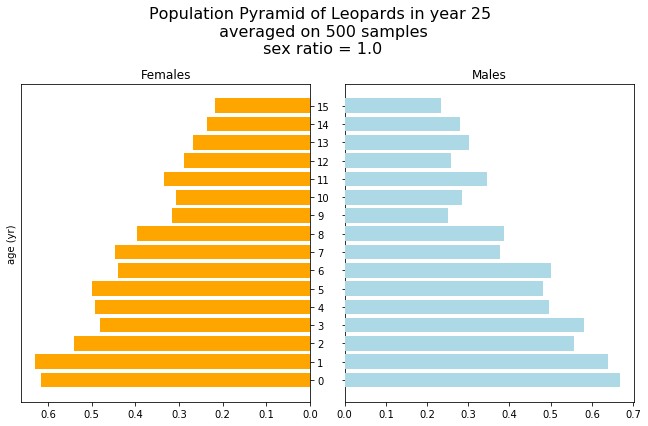

Wall time: 9.77 s


<Figure size 432x288 with 0 Axes>

In [47]:
%%time

p_male = 3/6
sex_ratio = p_male / (1 - p_male)
years = 24
puberty_age = 3
mean_life_time = 15
# p_give_birth = 1
# lam = 0.5
max_age = 15

subadults_0 = np.array(np.concatenate(([[1, 1]], [[0, 0]], [[0, 0]]), axis = 0))
adults_0 = np.array([[1, 3]])



average_on = 500

population = p_pyramid_choice(adults_0, subadults_0, years, mean_life_time, puberty_age, max_age)
males   = population[:, 0]
females = population[:, 1]

for ave in range(average_on - 1):
    new_pop = p_pyramid_choice(adults_0, subadults_0, years, mean_life_time, puberty_age, max_age)
    males   = np.concatenate((males, new_pop[:, 0]), axis = 0)
    females =  np.concatenate((females, new_pop[:, 1]), axis = 0)


males   = males.reshape(-1, max_age+1)
females = females.reshape(-1, max_age+1)

males_m   = males.mean(axis = 0)
males_std = np.std(males, axis = 0)

females_m = females.mean(axis = 0) 
females_std = np.std(females, axis = 0)


ages = np.arange(max_age + 1)


fig, axes = plt.subplots(ncols=2, figsize = (9, 6) , sharey=True)

fig.suptitle(f"Population Pyramid of Leopards in year {years + 1}\n averaged on {average_on} samples\n sex ratio = {np.round(sex_ratio, 2)}", fontsize = 16)


# axes[0].barh(ages, females_m, xerr = females_std, align='center', color='orange', zorder=10)
axes[0].barh(ages, females_m, align='center', color='orange', zorder=10)
axes[0].set(title='Females')
# axes[1].barh(ages, males_m, xerr = males_std, align='center', color='lightblue', zorder=10)
axes[1].barh(ages, males_m, align='center', color='lightblue', zorder=10)
axes[1].set(title='Males')

axes[0].invert_xaxis()
axes[0].set(yticks = ages, yticklabels = ages)
axes[0].yaxis.tick_right()
axes[0].set_ylabel("age (yr)")


fig.tight_layout()
fig.subplots_adjust(wspace = 0.12)
fig.subplots_adjust(top = 0.80)
plt.show()

plt.savefig("p_pyramid_choice.png")

### Captivity 

In [12]:
def born_choice(parents):
    nm, nf = parents
    if nm != 0:
        childs = random.choices([0, 1, 2, 3], weights = [0.35, 0.25, 0.35, 0.05], k = nf) #probilities have been tuned
        childs = int(np.sum(childs))
    else:
        childs = 0
    determine_sex = np.random.uniform(0, 1, childs)
    where = np.where(determine_sex < p_male)
    male_newborn   = np.size(where)
    female_newborn = childs - male_newborn
    newborn = [male_newborn, female_newborn]
    
    return newborn

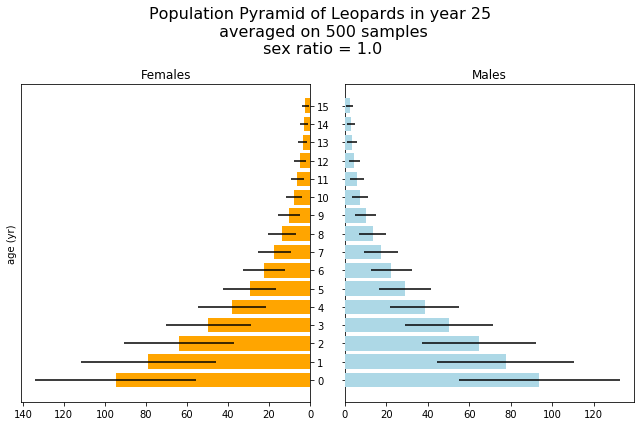

Wall time: 8.74 s


In [14]:
%%time

p_male = 3/6
sex_ratio = p_male / (1 - p_male)
years = 24
puberty_age = 3
mean_life_time = 15
# p_give_birth = 1
# lam = 0.5
max_age = 15

subadults_0 = np.array(np.concatenate(([[1, 1]], [[0, 0]], [[0, 0]]), axis = 0))
adults_0 = np.array([[1, 3]])



average_on = 500

population = p_pyramid_choice(adults_0, subadults_0, years, mean_life_time, puberty_age, max_age)
males   = population[:, 0]
females = population[:, 1]

for ave in range(average_on - 1):
    new_pop = p_pyramid_choice(adults_0, subadults_0, years, mean_life_time, puberty_age, max_age)
    males   = np.concatenate((males, new_pop[:, 0]), axis = 0)
    females =  np.concatenate((females, new_pop[:, 1]), axis = 0)


males   = males.reshape(-1, max_age+1)
females = females.reshape(-1, max_age+1)

males_m   = males.mean(axis = 0)
males_std = np.std(males, axis = 0)

females_m = females.mean(axis = 0) 
females_std = np.std(females, axis = 0)


ages = np.arange(max_age + 1)


fig, axes = plt.subplots(ncols=2, figsize = (9, 6) , sharey=True)

fig.suptitle(f"Population Pyramid of Leopards in year {years + 1}\n averaged on {average_on} samples\n sex ratio = {np.round(sex_ratio, 2)}", fontsize = 16)


axes[0].barh(ages, females_m, xerr = females_std, align='center', color='orange', zorder=10)
# axes[0].barh(ages, females_m, align='center', color='orange', zorder=10)
axes[0].set(title='Females')
axes[1].barh(ages, males_m, xerr = males_std, align='center', color='lightblue', zorder=10)
# axes[1].barh(ages, males_m, align='center', color='lightblue', zorder=10)
axes[1].set(title='Males')

axes[0].invert_xaxis()
axes[0].set(yticks = ages, yticklabels = ages)
axes[0].yaxis.tick_right()
axes[0].set_ylabel("age (yr)")


fig.tight_layout()
fig.subplots_adjust(wspace = 0.12)
fig.subplots_adjust(top = 0.80)
plt.show()
